In [12]:
import pandas as pd

from transforms.dataframes.preprocess import dataframe_preprocess
from transforms.dataframes.is_success import dataframe_is_success

DATA = dataframe_is_success(dataframe_preprocess(pd.read_csv("data/kickstarter.csv")))
DATA.head()

,ID,name,main_category,sub_category,country,currency,launched,deadline,goal,pledged,backers,usd_pledged_real,usd_goal_real,is_success
0,1000002330,The Songs of Adelaide & Abullah,Publishing,Poetry,United Kingdom,GBP,2015-08-11 12:12:28+00:00,2015-10-09,1000.0,0.0,0,0.0,1533.95,False
1,1000003930,Greeting From Earth: ZGAC Arts Capsule For ET,Film & Video,Narrative Film,United States,USD,2017-09-02 04:43:57+00:00,2017-11-01,30000.0,2421.0,15,2421.0,30000.00,False
2,1000004038,Where is Hank?,Film & Video,Narrative Film,United States,USD,2013-01-12 00:20:50+00:00,2013-02-26,45000.0,220.0,3,220.0,45000.00,False
3,1000007540,ToshiCapital Rekordz Needs Help to Complete Album,Music,Music,United States,USD,2012-03-17 03:24:11+00:00,2012-04-16,5000.0,1.0,1,1.0,5000.00,False
5,1000014025,Monarch Espresso Bar,Food,Restaurants,United States,USD,2016-02-26 13:38:27+00:00,2016-04-01,50000.0,52375.0,224,52375.0,50000.00,True


適当に木に入れてみて知見を得てみるか

In [13]:
from sklearn.preprocessing import LabelEncoder

MAIN_CATEGORY_ENCODER = LabelEncoder()
MAIN_CATEGORY_ENCODER.fit(DATA.main_category)
MAIN_CATEGORY_ENCODER.transform(DATA.main_category)


array([12,  6,  6, ...,  6, 13,  0])

In [14]:
pd.get_dummies(DATA.main_category)

,Art,Comics,Crafts,Dance,Design,Fashion,Film & Video,Food,Games,Journalism,Music,Photography,Publishing,Technology,Theater
0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
5,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
378647,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
378650,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
378651,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
378652,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0


In [44]:
import datetime
import time


def to_unixtime(datetime: datetime.datetime) -> float:
    return time.mktime(datetime.timetuple())


DATA_FOR_TREE = pd.concat(
    [
        # ダミー変数類
        pd.get_dummies(DATA.main_category),
        pd.get_dummies(DATA.sub_category),
        pd.get_dummies(DATA.country),
        pd.get_dummies(DATA.currency),
        # 時刻はunixtimeにする
        pd.DataFrame(
            {
                "launched": DATA.launched.apply(to_unixtime),
                "deadline": DATA.deadline.apply(to_unixtime),
            }
        ),
        # そのまま
        DATA[
            [
                "goal",
                "pledged",
                "backers",
                "usd_pledged_real",
                "usd_goal_real",
            ]
        ],
        # 目的変数
        pd.DataFrame(
            {"is_success": LabelEncoder().fit_transform(DATA.is_success)},
            index=DATA.index,
        ),
    ],
    axis=1,
)

DATA_FOR_TREE.head()


,Art,Comics,Crafts,Dance,Design,Fashion,Film & Video,Food,Games,Journalism,...,SGD,USD,launched,deadline,goal,pledged,backers,usd_pledged_real,usd_goal_real,is_success
0,0,0,0,0,0,0,0,0,0,0,...,0,0,1.439295e+09,1.444349e+09,1000.0,0.0,0,0.0,1533.95,0
1,0,0,0,0,0,0,1,0,0,0,...,0,1,1.504327e+09,1.509494e+09,30000.0,2421.0,15,2421.0,30000.00,0
2,0,0,0,0,0,0,1,0,0,0,...,0,1,1.357950e+09,1.361837e+09,45000.0,220.0,3,220.0,45000.00,0
3,0,0,0,0,0,0,0,0,0,0,...,0,1,1.331955e+09,1.334534e+09,5000.0,1.0,1,1.0,5000.00,0
5,0,0,0,0,0,0,0,1,0,0,...,0,1,1.456494e+09,1.459469e+09,50000.0,52375.0,224,52375.0,50000.00,1


In [65]:
from sklearn.tree import DecisionTreeClassifier, plot_tree

TREE = DecisionTreeClassifier(
    max_depth=4
).fit(
    DATA_FOR_TREE.drop("is_success", axis=1),
    DATA_FOR_TREE.is_success,
)

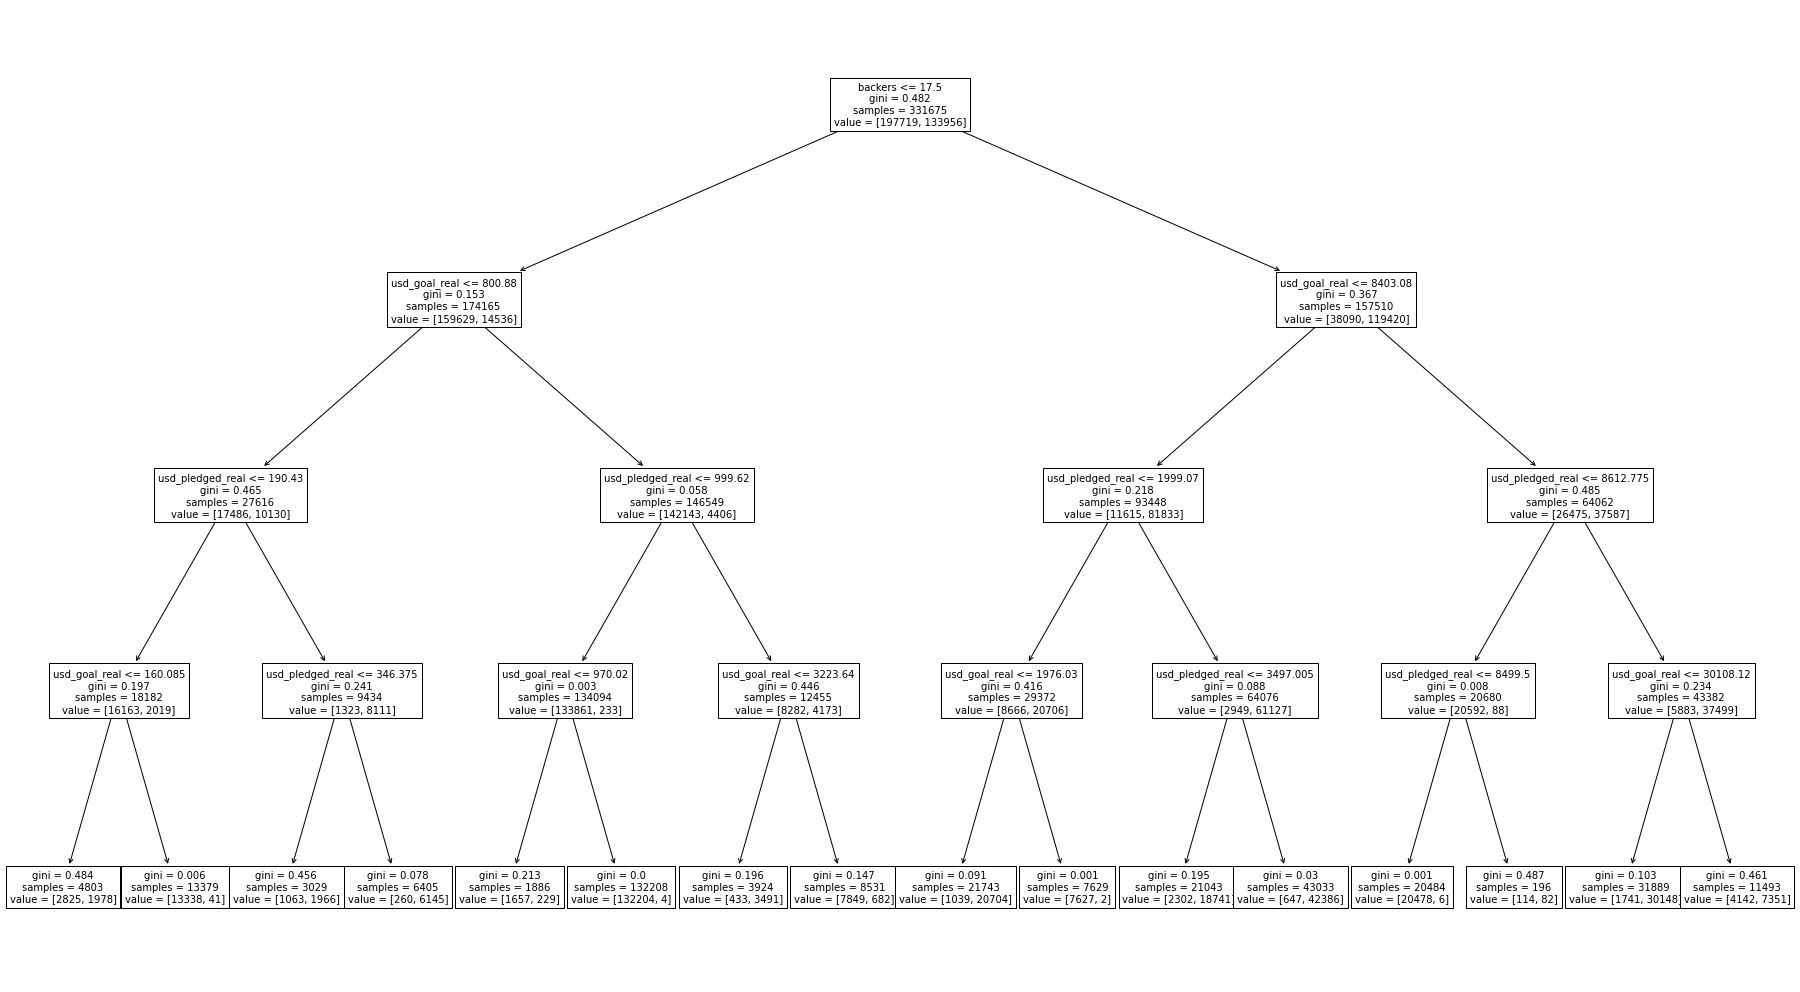

In [66]:
import matplotlib.pyplot as plt

plt.figure(figsize=(32, 18))
_ = plot_tree(
    TREE,
    feature_names=DATA_FOR_TREE.drop("is_success", axis=1).columns,
    fontsize=10
)
plt.show()